# Soma Detection Analysis of Whole-Brain Light-Sheet Images

## 1. Before Using this notebook

### 1a. Install brainlit, and dependencies
### 1b. Write images to s3 using CloudReg
    - e.g. python -m cloudreg.scripts.create_precomputed_volumes --s3_input_paths /mnt/NAS/SmartSPIM_Data/2022_03_02/20220302_14_40_04_8529_destriped_DONE/Ex_561_Em_600_stitched --s3_output_paths  s3://smartspim-precomputed-volumes/2022_03_02/8529/Ch_561_v2  --voxel_size 1.83 1.83 2 --num_procs 24 --resample_iso False
### 1c. Make point annotations in neuroglancer to identify subvolumes for validation (and possible training)
    - instructions: https://neurodata.io/help/neuroglancer-pt-annotations/
    ,
    {
    "type":"pointAnnotation",
    "name": "soma_val",
    "points": []
    },
    {
    "type":"pointAnnotation",
    "name": "nonsoma_val",
    "points":[]
    }
### 1d. Update soma_data.py file

### \* Inputs \*

In [ ]:
from brainlit.preprocessing import removeSmallCCs
from brainlit.BrainLine.data.soma_data import brain2paths, brain2centers
from brainlit.BrainLine.analyze_results import SomaDistribution
from brainlit.BrainLine.util import (
    json_to_points,
    find_atlas_level_label,
    fold,
    setup_atlas_graph,
    get_atlas_level_nodes,
    download_subvolumes
)
from brainlit.BrainLine.apply_ilastik import ApplyIlastik, ApplyIlastik_LargeImage, plot_results, examine_threshold
from brainlit.BrainLine.parse_ara import *
import xml.etree.ElementTree as ET
from cloudreg.scripts.transform_points import NGLink
from brainlit.BrainLine.imports import *

%gui qt5

In [ ]:
brainlit_path = Path(os.path.abspath(""))
brainlit_path = brainlit_path.parents[3]
print(f"Path to brainlit: {brainlit_path}")

for id in brain2paths.keys():
    if "base" in brain2paths[id].keys() and "val_info" in brain2paths[id].keys():
        base = brain2paths[id]["base"]
        if "http" in base:
            print(f"Sample {id}: http in basepath, which may cause write errors")

        try:
            url = brain2paths[id]["val_info"]["url"]
            layer = brain2paths[id]["val_info"]["somas_layer"]
            pts = json_to_points(url)[layer]
            layer = brain2paths[id]["val_info"]["nonsomas_layer"]
            pts = json_to_points(url)[layer]
        except:
            print(f"Sample {id}: Error finding validation annotations with val_info")

        if "train_info" in brain2paths[id].keys():
            try:
                url = brain2paths[id]["train_info"]["url"]
                layer = brain2paths[id]["train_info"]["somas_layer"]
                pts = json_to_points(url)[layer]
                layer = brain2paths[id]["train_info"]["nonsomas_layer"]
                pts = json_to_points(url)[layer]
            except:
                print(f"Sample {id}: Error finding training annotations with train_info")
    else:
        print(f"Sample {id}: Does not conform to desired format")

## 2. Download benchmark data

### \*Inputs\*

In [ ]:
brain = "test"  # brain ID
soma_data_dir = str(brainlit_path.parents[0]) + "/" # path to directory where training/validation data should be stored
dataset_to_save = "val"  # train or val

antibody_layer = "antibody"
background_layer = "background"
endogenous_layer = "endogenous"

### Setup paths

In [ ]:
cvol_base = brain2paths[brain]["base"]
layer_names = [antibody_layer, background_layer, endogenous_layer]

if brain not in brain2paths.keys():
    raise ValueError(f"brain {brain} not an entry in brain2paths in axon_data.py file")

if f"{dataset_to_save}_info" not in brain2paths[
    brain
].keys() or dataset_to_save not in ["train", "val"]:
    raise ValueError(f"{dataset_to_save}_info not in brain2paths[{brain}].keys()")


for layer in [antibody_layer, background_layer, endogenous_layer]:
    try:
        CloudVolume(cvol_base + layer)
    except:
        print(f"Sample {id}: Layer {layer} not found in {cvol_base}")

### Download data

In [ ]:
download_subvolumes(soma_data_dir, brain_id = brain, layer_names = layer_names, dataset_to_save = dataset_to_save, object_type="soma")

## 3. View downloaded data (optional)

### \*Inputs\*

In [ ]:
fname = "/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/braintest/val/2936_4243_1587_pos.h5" # path to file for viewing
scale = [1.8, 1.8, 2]  # voxel size in microns

In [ ]:
with h5py.File(fname, "r") as f:
    pred = f.get("image_3channel")
    image_fg = pred[0, :, :, :]
    image_bg = pred[1, :, :, :]
    image_endo = pred[2, :, :, :]

viewer = napari.Viewer(ndisplay=3)
viewer.add_image(image_fg, scale=scale)
viewer.add_image(image_bg, scale=scale)
viewer.add_image(image_endo, scale=scale)
viewer.scale_bar.visible = True
viewer.scale_bar.unit = "um"

## 4. Apply ilastik to validation data

You can do this programmatically (below), or you can use the ilastik GUI (which is sometimes faster)

### \* Inputs \*

In [ ]:
project_path = f"/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/matt_soma_rabies_pix_3ch.ilp"  # path to ilastik model to be used
ilastik_path = "/Applications/ilastik-1.4.0b21-OSX.app/Contents/ilastik-release/run_ilastik.sh"
brains = [brain]

In [ ]:
applyilastik = ApplyIlastik(ilastk_path = ilastik_path, project_path = project_path, brains_path = soma_data_dir, brains = brains)
applyilastik.process_subvols()
#applyilastik.move_results()

### \*Inputs \*
- identify files that have two somas in variable below. Since voxel coordinates are likely to be unique across samples, the file names below do not include sample IDs.

In [ ]:
doubles = [
] # e.g. ["3972_1636_1575_pos_Probabilities.h5",]

## 5. Check Results

### Validation

In [ ]:
plot_results(data_dir = soma_data_dir, brain_id = brain, object_type="soma", positive_channel=0, doubles = doubles)

### If results above are not adequate, improve model and try again

In my case, I identify more subvolumes from the sample at hand using the same process as for validation data, and add it as training data to the model and retrain.

### Examine best threshold

In [ ]:
examine_threshold(data_dir = soma_data_dir, brain_id = brain, threshold = 0.28, object_type="soma", positive_channel=0, doubles = doubles)

## 6. Make Annotation layers

### Transformed layers

In [ ]:
atlas_vol = CloudVolume(
    "precomputed://https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_10um/annotation_10um_2017"
)
for layer in [
    antibody_layer,
    background_layer,
]:  # axon_mask is transformed into an image because nearest interpolation doesnt work well after downsampling
    layer_path = brain2paths[brain]["base"] + layer + "_transformed"
    info = CloudVolume.create_new_info(
        num_channels=1,
        layer_type="image",
        data_type="uint16",  # Channel images might be 'uint8'
        encoding="raw",  # raw, jpeg, compressed_segmentation, fpzip, kempressed
        resolution=atlas_vol.resolution,  # Voxel scaling, units are in nanometers
        voxel_offset=atlas_vol.voxel_offset,
        chunk_size=[32, 32, 32],  # units are voxels
        volume_size=atlas_vol.volume_size,  # e.g. a cubic millimeter dataset
    )
    vol_mask = CloudVolume(layer_path, info=info)
    vol_mask.commit_info()

## 7. Apply ilastik to whole image

### \* Inputs \*
You can use the notebook code below or the script using `soma_detect_image.py`

In [ ]:
threshold = 0.28  # threshold to use for ilastik
data_dir = soma_data_dir + "brainr_temp/" # "/data/tathey1/matt_wright/brainr_temp/"  # directory to store temporary subvolumes for segmentation
results_dir = soma_data_dir + "brainr_results/"  # directory to store coordinates of soma detections

# Ilastik will run in "headless mode", and the following paths are needed to do so:
ilastik_path = "/Applications/ilastik-1.4.0b21-OSX.app/Contents/ilastik-release/run_ilastik.sh" #"/data/tathey1/matt_wright/ilastik/ilastik-1.4.0rc5-Linux/run_ilastik.sh"  # path to ilastik executable
ilastik_project = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/matt_soma_rabies_pix_3ch.ilp" #"/data/tathey1/matt_wright/ilastik/soma_model/matt_soma_rabies_pix_3ch.ilp"  # path to ilastik project

max_coords = [3072, 4352, 1792] #-1 if you want to process the whole dimension
ncpu = 1 #16  # number of cores to use for detection
chunk_size = [256, 256, 256]#[256, 256, 300]

In [ ]:
layer_names=[antibody_layer, background_layer, endogenous_layer]

ilastik_largeimage = ApplyIlastik_LargeImage(ilastik_path = ilastik_path, ilastik_project=ilastik_project, object_type = "soma", results_dir=results_dir, ncpu=1)
ilastik_largeimage.apply_ilastik_parallel(brain_id=brain, layer_names=layer_names, threshold=threshold, data_dir=data_dir, chunk_size=chunk_size, max_coords=max_coords)

Before this step you will need to make sure that the original data is being served to neuroglancer. For example, in this case, our data is local so we can serve it with the command:

`python cors_webserver.py -d "<path-to-brainlit>/brainlit/brainlit/BrainLine/data/example" -p 9010`

which needs to be run in the neuroglancer folder (git clone from here: https://github.com/google/neuroglancer)

In [ ]:
ilastik_largeimage.collect_soma_results(brain_id="test")

## 8. Register volume and transform data to atlas space using CloudReg

### 8a. You need to find an initial affine alignment using cloudreg.scripts.registration.get_affine_matrix. For example: 

A link to the ARA parcellation is:

`precomputed://https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_10um/annotation_10um_2017`

And some python commands to help with affine alignment is:

```
from cloudreg.scripts.registration import get_affine_matrix
get_affine_matrix([1,1,1], [15,0,0], "PIR", "RAI", 1.15, "precomputed://https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_10um/annotation_10um_2017")
```

### 8b. Run registration using cloudreg.scripts.registration. For example:

```
python -m cloudreg.scripts.registration -input_s3_path precomputed://s3://smartspim-precomputed-volumes/2023_01_20/MPRRabies/Ch_561 --output_s3_path precomputed://s3://smartspim-precomputed-volumes/2023_01_20/MPRRabies/atlas_to_target --atlas_s3_path https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_50um/average_50um --parcellation_s3_path https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_10um/annotation_10um_2017 --atlas_orientation PIR -orientation RPI --rotation 0 0 0 --translation 0 0 0 --fixed_scale 1.07 -log_s3_path precomputed://s3://smartspim-precomputed-volumes/2023_01_20/MPRRabies/atlas_to_target --missing_data_correction True --grid_correction False --bias_correction True --regularization 5000.0 --iterations 3000 --registration_resolution 100
```

### 8c. Transform data to atlas space using CloudReg

### Soma coordinates

```
python -m cloudreg.scripts.transform_points --target_viz_link https://viz.neurodata.io/?json_url=https://json.neurodata.io/v1?NGStateID=6ti276yAxXF_Rw --atlas_viz_link https://ara.viz.neurodata.io/?json_url=https://json.neurodata.io/v1?NGStateID=HvyNDGaPsd1wyg --affine_path /mnt/NAS/Neuroglancer\ Data/  --velocity_path /mnt/NAS/Neuroglancer\ Data/  --transformation_direction atlas
```

or

```
python -m cloudreg.scripts.transform_points --target_viz_link https://viz.neurodata.io/?json_url=https://json.neurodata.io/v1?NGStateID=05Fhxt5VBT-_1A --atlas_viz_link https://ara.viz.neurodata.io/?json_url=https://json.neurodata.io/v1?NGStateID=HvyNDGaPsd1wyg --affine_path /cis/home/tathey/MPRRabies_Ch_561_registration/downloop_1_A.mat   --velocity_path /cis/home/tathey/MPRRabies_Ch_561_registration/downloop_1_v.mat  --transformation_direction atlas
```

This will produce a neuroglancer link with the transformed soma coordinates, which should be added to `soma_data.py` under the `somas_atlas_url` key. Then the code below, or `soma_brainrender.py`, can be used to visualize the data.

### Image

```
python -m cloudreg.scripts.transform_data --target_layer_source precomputed://s3://smartspim-precomputed-volumes/2022_09_20/887/Ch_647 --transformed_layer_source precomputed://s3://smartspim-precomputed-volumes/2022_09_20/887/Ch_647_transformed --affine_path /cis/home/tathey/887_Ch_561_registration/downloop_1_A.mat  --velocity_path /cis/home/tathey/887_Ch_561_registration/downloop_1_v.mat
```

## 9. View coronal maps

### \*Inputs\*

In [15]:
# colors = {
#     "tph2 vglut3": "blue",
#     "tph2 gad2": "red",
#     "gad2 vgat": "green",
# }  # colors for different genotypes
colors = {
    "test_type": "blue",
}  # colors for different genotypes
symbols = ["o", "+", "^", "vbar"]
brain_ids = ["test"]
fold_on = True


In [16]:
sd = SomaDistribution(brain_ids = brain_ids)
sd.napari_coronal_section(z=1000, subtype_colors = colors, symbols = symbols, fold_on = fold_on)

Brain test: Collecting atlas space soma points from layer: transformed_points


Processing labels: 100%|██████████| 92/92 [00:01<00:00, 54.04it/s]













Processing brains in z=1000: 100%|██████████| 1/1 [00:00<00:00, 16.72it/s]


## 10. Display bar charts

Brain test: Collecting atlas space soma points from layer: transformed_points
Populating: Cerebral cortex
Populating: Olfactory areas
Populating: Hippocampal formation
Populating: Striatum
Populating: Bed nuclei of the stria terminalis
Populating: Hypothalamus
Populating: Thalamus
Populating: Lateral habenula
Populating: Cerebellar nuclei
Populating: Midbrain
Populating: Hindbrain
Populating: Amygdalar Nuclei


/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/brainlit/BrainLine/analyze_results.py:234: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  bplot.set_xscale("log")


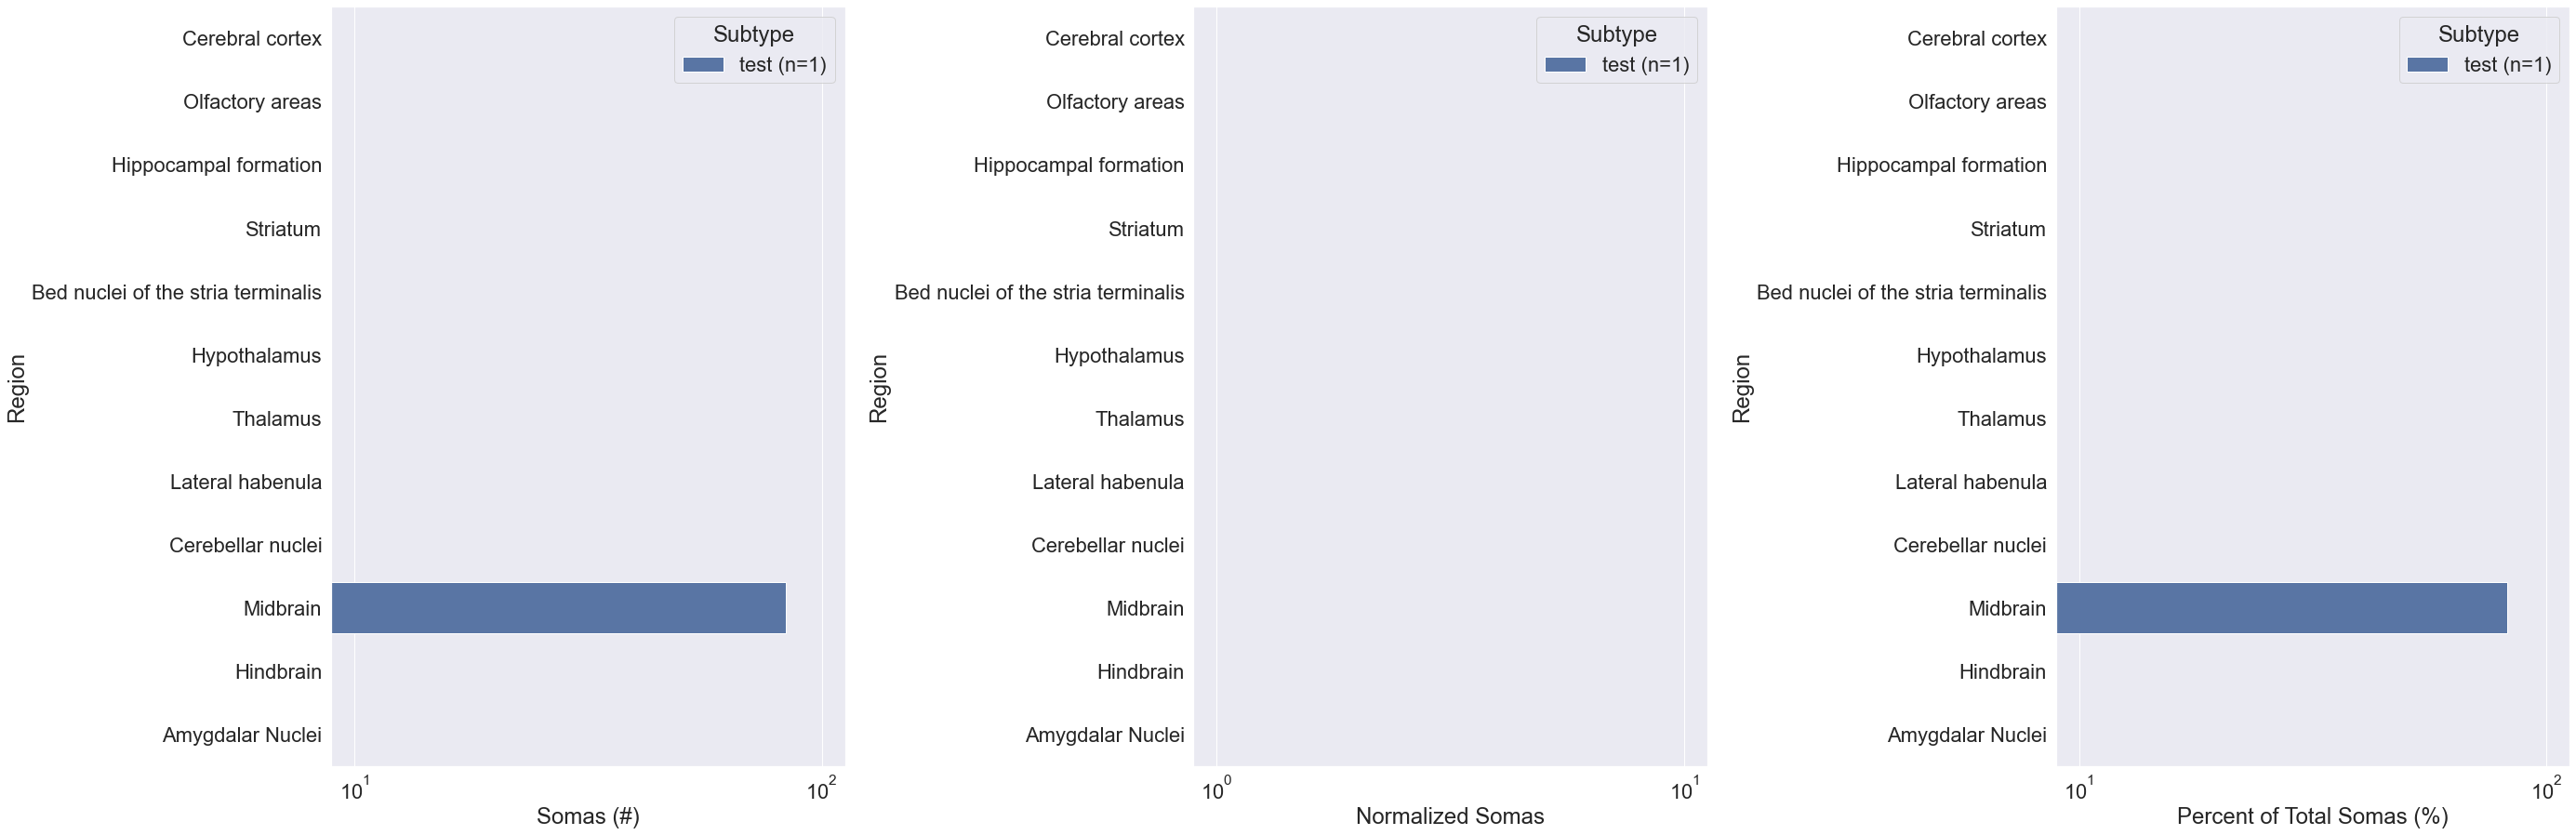

In [17]:
regions = [
    688,  # cerebral cortex
    698,  # olfactory areas
    1089,  # hippocampal formation
    # 583, # claustrum
    477,  # striatum
    # 803, # pallidum
    351,  # bed nuclei of stria terminalis
    # 703, #cortical subplate
    1097,  # hypothalamus
    549,  # thalamus
    186,  # lateral habenula
    519,  # cerebellar nuclei
    313,  # midbrain
    1065,  # hindbrain
]  # allen atlas region IDs to be shown
# see: https://connectivity.brain-map.org/projection/experiment/480074702?imageId=480075280&initImage=TWO_PHOTON&x=17028&y=11704&z=3

composite_regions = {
    "Amygdalar Nuclei": [131, 295, 319, 780]
}  # Custom composite allen regions where key is region name and value is list of allen regions

brain_ids = ["test"]
sd = SomaDistribution(brain_ids = brain_ids)
sd.region_barchart(regions, composite_regions=composite_regions, normalize_region=872)
